In [444]:
import numpy as np 
import matplotlib.pyplot as plt
from utility import create_graphs2D, create_graphs1D

In [445]:
ITERATIONS = 100
observed_x_bins = 60
observed_y_bins = 60
unfolded_x_bins = 30
unfolded_y_bins = 30

In [446]:
#rng generator from numpy
rng = np.random.default_rng()
#create fake data
x_1 = rng.normal(0.3, 0.1, 30000)
y_1 = rng.normal(0.75, 0.1, 30000)

x_2 = rng.normal(0.72, 0.16, 45000)
y_2 = rng.normal(0.44, 0.16, 45000)

x_3 = rng.normal(0.55, 0.08, 10000)
y_3 = rng.normal(0.65, 0.08, 10000)

x_uniform = rng.uniform(0, 1, 20000)
y_uniform = rng.uniform(0, 1, 20000)
#combine into 2
x_true_unfiltered = np.hstack((x_1, x_2, x_3, x_uniform))
y_true_unfiltered = np.hstack((y_1, y_2, y_3, y_uniform))
#remove any values outside possible range
cond1 = (x_true_unfiltered > 0) & (x_true_unfiltered < 1)
cond2 = (y_true_unfiltered > 0) & (y_true_unfiltered < 1)

x_true_full = x_true_unfiltered[cond1&cond2]
y_true_full = y_true_unfiltered[cond1&cond2]
#smear the data
x_resolution_offset = rng.normal(0, 0.05, len(x_true_full))
y_resolution_offset = rng.normal(0, 0.05, len(y_true_full))
x_recon_unfiltered = x_true_full + x_resolution_offset
y_recon_unfiltered = y_true_full + y_resolution_offset
#assume that the true data can only be found in the range (0, 1)
cond3 = (x_recon_unfiltered> 0) & (x_recon_unfiltered < 1)
cond4 = (y_recon_unfiltered> 0) & (y_recon_unfiltered < 1)

#recon data with acceptance lost
x_recon = x_recon_unfiltered[cond3&cond4]
y_recon = y_recon_unfiltered[cond3&cond4]
#this true data is really only partial, use true_full for normalizing A matrix
x_true =  x_true_full[cond3&cond4] 
y_true =  y_true_full[cond3&cond4]

In [447]:
true_binned = np.histogram2d(x_true, y_true, bins=(observed_x_bins,observed_y_bins))[0]
recon_binned = np.histogram2d(x_recon, y_recon, bins=(observed_x_bins,observed_y_bins))[0]

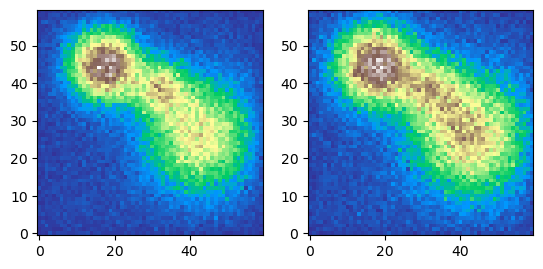

In [448]:
#visualization
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(true_binned.T, cmap='terrain', interpolation='nearest', origin='lower')
ax2.imshow(recon_binned.T, cmap='terrain', interpolation='nearest', origin='lower')
plt.show()

In [449]:
#Compute A Matrix 
A = np.histogramdd((x_recon, x_true, y_recon, y_true), bins=(observed_x_bins, unfolded_x_bins, observed_y_bins, unfolded_y_bins))[0]
# Normalize data, it must be the full set of true data, not trimmed down at all
true_binned_full = np.histogram2d(x_true_full, y_true_full, bins=(unfolded_x_bins,unfolded_y_bins))[0]
for i in range(len(A)):
    for j in range(len(true_binned_full)):
        A[i][j] /= true_binned_full[j] + 1e-12
#alpha for acceptance error
alpha = np.sum(np.sum(A, axis=2), axis=0)
print(alpha.shape)

(30, 30)


In [450]:
flat_recon_bins = recon_binned.flatten()
flat_A = A.transpose(0, 2, 1, 3).reshape(observed_x_bins * observed_y_bins, unfolded_x_bins * unfolded_y_bins)
flat_alpha = alpha.flatten()
print(flat_alpha)

[0.26086957 0.82352941 0.73684211 0.57692308 0.4        0.52173913
 0.8        0.5        0.58823529 0.56       0.6        0.77419355
 0.66666667 0.36842105 0.75       0.57692308 0.59259259 0.76666667
 0.7        0.78378378 0.64102564 0.75       0.68571429 0.61538462
 0.76666667 0.60465116 0.73684211 0.45833333 0.48275862 0.36
 0.6        0.86363636 0.78571429 0.9047619  0.94444444 0.94444444
 0.70588235 0.95454545 0.83333333 0.95652174 0.94736842 0.85714286
 0.66666667 0.88235294 0.6        0.77142857 0.90909091 0.76666667
 0.85294118 0.75       0.85       0.9        0.76923077 0.80952381
 0.76666667 0.79487179 0.89285714 0.65217391 0.87096774 0.43478261
 0.42857143 0.82352941 0.95454545 1.         0.875      1.
 0.86666667 0.875      0.95454545 0.88235294 1.         0.94736842
 0.82142857 1.         0.92       0.96551724 0.88461538 0.90625
 0.89130435 0.96491228 0.97014925 0.94520548 0.94594595 0.9516129
 0.96078431 0.93181818 0.97619048 0.95       0.76923077 0.62857143
 0.75       0

In [451]:
def cal_llh(hist_1, hist_2):
    return (-2 * (np.sum(hist_1 * np.log(hist_2 + 1e-12) - hist_2) - np.sum(hist_1 * np.log(hist_1 + 1e-12) - hist_1)))

3665.2362091113464
4


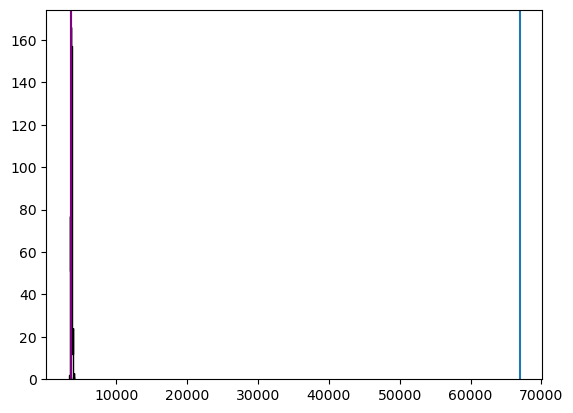

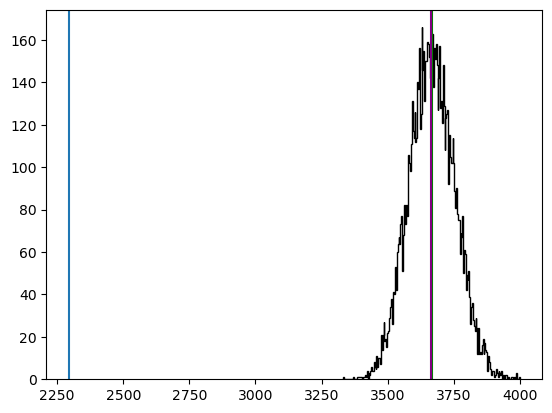

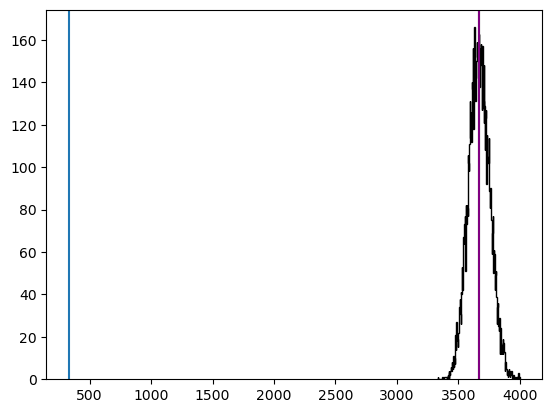

In [452]:
#Implementation of the R-L algorithm
unfolded = np.array([len(x_true_full) / (unfolded_x_bins * unfolded_y_bins)] * (unfolded_x_bins * unfolded_y_bins)) #starting with uniform dist

sampled_recon = [cal_llh(rng.poisson(flat_recon_bins), flat_recon_bins) for _ in range(10000)]
sampled_median = np.median(sampled_recon)
iter_count = 0
N_iter = np.matmul(flat_A, unfolded)
llh = cal_llh(flat_recon_bins, N_iter)
plt.figure()
plt.hist(sampled_recon, 200, histtype='step', color = 'black')
plt.axvline(llh)
plt.axvline(np.mean(sampled_recon), color = 'green')
plt.axvline(np.median(sampled_recon), color = 'purple')
print(sampled_median)
# while llh > sampled_median:
for _ in range(2):
    d_k = np.matmul(flat_A, unfolded)
    ratio = flat_recon_bins / (d_k + 1e-12)  # avoid division by zero
    unfolded = unfolded * (flat_A.T @ ratio) / (flat_alpha + 1e-12)

    N_iter = np.matmul(flat_A, unfolded)
    llh = cal_llh(flat_recon_bins, N_iter)
    iter_count += 1

    plt.figure()
    plt.hist(sampled_recon, 200, histtype='step', color = 'black')
    plt.axvline(llh)
    plt.axvline(np.mean(sampled_recon), color = 'green')
    plt.axvline(np.median(sampled_recon), color = 'purple')

# for _ in range(iter_count):
#     d_k = np.matmul(flat_A, unfolded)
#     ratio = flat_recon_bins / (d_k + 1e-12)  # avoid division by zero
#     unfolded = unfolded * (flat_A.T @ ratio) / (flat_alpha + 1e-12)

print(iter_count * 2)

In [453]:
final_unfolded = unfolded.reshape(unfolded_x_bins, unfolded_y_bins)

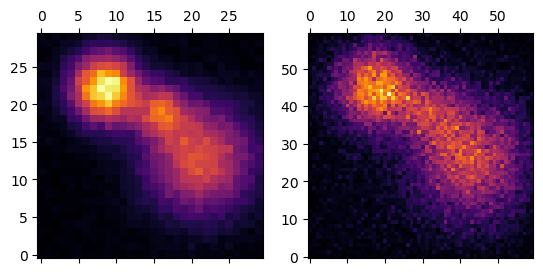

In [454]:
#visualization
fig, (ax3, ax4) = plt.subplots(1,2)
ax3.matshow(true_binned_full.T, cmap='inferno', interpolation='nearest', origin='lower')
ax4.matshow(rng.poisson(flat_recon_bins).reshape(60, 60).T, cmap='inferno', interpolation='nearest', origin='lower')
plt.show()


In [455]:
print(np.max(recon_binned))
print(np.max(final_unfolded))
print(np.max(true_binned_full))

127.0
480.3886521842745
542.0


In [456]:
print(np.sum(recon_binned))
print(np.sum(true_binned_full))

100150.0
102846.0


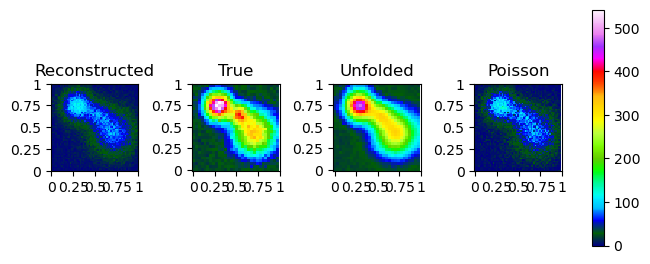

In [457]:
ticks = [[[0, 1], [0, 1]], [[0, 1], [0, 1]], [[0, 1], [0, 1]], [[0, 1], [0, 1]]]
create_graphs2D([recon_binned.T, true_binned_full.T, final_unfolded.T, rng.poisson(flat_recon_bins).reshape(60, 60).T], ['Reconstructed', 'True', 'Unfolded', 'Poisson'], ticks, cmap='gist_ncar')

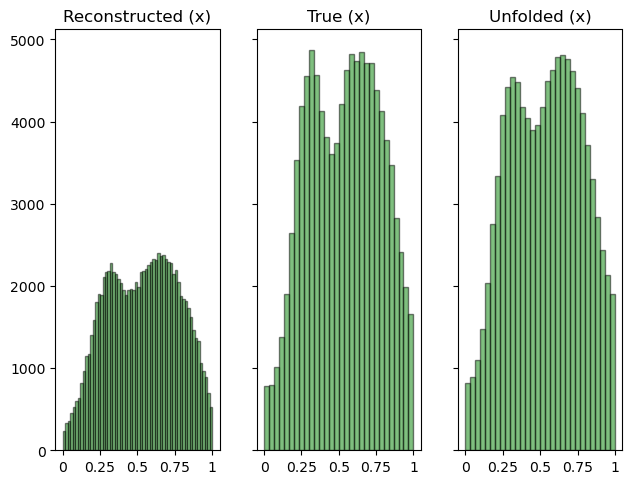

In [458]:
create_graphs1D([np.sum(recon_binned, axis=1), np.sum(true_binned_full, axis=1), np.sum(final_unfolded, axis=1)], ['Reconstructed (x)', 'True (x)', 'Unfolded (x)'], [[0, 1], [0, 1], [0, 1]], color = 'green', sharey=True)

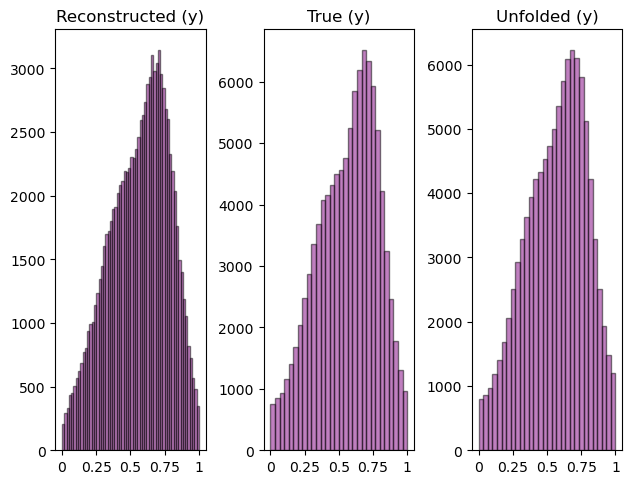

In [459]:
create_graphs1D([np.sum(recon_binned, axis=0), np.sum(true_binned_full, axis=0), np.sum(final_unfolded, axis=0)], ['Reconstructed (y)', 'True (y)', 'Unfolded (y)'], [[0, 1], [0, 1], [0, 1]], color = 'purple')